# Dry Eye Disease Prediction with XGBoost

This notebook covers data preprocessing, feature engineering, and XGBoost model training for predicting Dry Eye Disease.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 2. Load and Explore Data

In [2]:
df = pd.read_csv('Dry Eye Disease/Dry_Eye_Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")

Dataset shape: (20000, 26)

Column names:
['Gender', 'Age', 'Sleep duration', 'Sleep quality', 'Stress level', 'Blood pressure', 'Heart rate', 'Daily steps', 'Physical activity', 'Height', 'Weight', 'Sleep disorder', 'Wake up during night', 'Feel sleepy during day', 'Caffeine consumption', 'Alcohol consumption', 'Smoking', 'Medical issue', 'Ongoing medication', 'Smart device before bed', 'Average screen time', 'Blue-light filter', 'Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye', 'Dry Eye Disease']


In [3]:
df.head()

,Gender,Age,Sleep duration,Sleep quality,Stress level,Blood pressure,Heart rate,Daily steps,Physical activity,Height,...,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease
0,F,24,9.5,2,1,137/89,67,3000,31,161,...,N,Y,Y,N,8.7,N,Y,Y,N,Y
1,M,39,9.6,2,3,108/64,60,12000,74,164,...,N,Y,Y,N,9.6,Y,N,N,Y,Y
2,F,45,5.4,1,5,134/81,95,12000,93,179,...,N,N,N,Y,4.0,N,Y,N,N,N
3,F,45,5.4,4,5,110/90,78,19000,32,160,...,N,Y,N,N,7.6,N,Y,N,Y,N
4,F,42,5.7,3,2,99/67,72,4000,173,179,...,N,Y,N,N,3.5,N,Y,Y,N,Y


In [4]:
print("Data Info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       20000 non-null  object 
 1   Age                          20000 non-null  int64  
 2   Sleep duration               20000 non-null  float64
 3   Sleep quality                20000 non-null  int64  
 4   Stress level                 20000 non-null  int64  
 5   Blood pressure               20000 non-null  object 
 6   Heart rate                   20000 non-null  int64  
 7   Daily steps                  20000 non-null  int64  
 8   Physical activity            20000 non-null  int64  
 9   Height                       20000 non-null  int64  
 10  Weight                       20000 non-null  int64  
 11  Sleep disorder               20000 non-null  object 
 12  Wake up during night         20000 non-null  object 
 13  Feel 

In [5]:
print("Target Distribution:")
print(df['Dry Eye Disease'].value_counts())
print(f"\nPercentage:")
print(df['Dry Eye Disease'].value_counts(normalize=True) * 100)

Target Distribution:
Dry Eye Disease
Y    13037
N     6963
Name: count, dtype: int64

Percentage:
Dry Eye Disease
Y    65.185
N    34.815
Name: proportion, dtype: float64


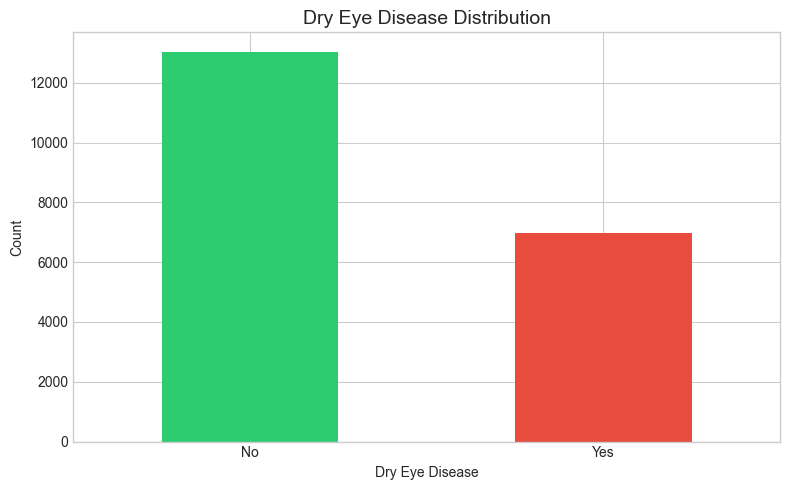

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
df['Dry Eye Disease'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Dry Eye Disease Distribution', fontsize=14)
ax.set_xlabel('Dry Eye Disease')
ax.set_ylabel('Count')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

In [7]:
numerical_cols = ['Age', 'Sleep duration', 'Sleep quality', 'Stress level', 
                  'Heart rate', 'Daily steps', 'Physical activity', 
                  'Height', 'Weight', 'Average screen time']
df[numerical_cols].describe()

,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Average screen time
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,31.422800,6.998245,2.997250,2.993750,79.912200,10536.900000,90.069750,174.865900,74.891850,5.519885
std,8.103717,1.731723,1.412283,1.407235,11.808279,5752.729186,52.317283,14.719903,14.733839,2.606305
min,18.000000,4.000000,1.000000,1.000000,60.000000,1000.000000,0.000000,150.000000,50.000000,1.000000
25%,24.000000,5.500000,2.000000,2.000000,70.000000,6000.000000,45.000000,162.000000,62.000000,3.300000
50%,31.000000,7.000000,3.000000,3.000000,80.000000,11000.000000,91.000000,175.000000,75.000000,5.500000
75%,39.000000,8.500000,4.000000,4.000000,90.000000,16000.000000,135.000000,188.000000,88.000000,7.800000
max,45.000000,10.000000,5.000000,5.000000,100.000000,20000.000000,180.000000,200.000000,100.000000,10.000000


## 3. Feature Engineering

### 3.1 Calculate BMI from Height and Weight

BMI (Body Mass Index) is an important factor that can affect dry eye disease risk. According to medical research, obesity may influence tear production and eye health.

In [8]:
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

print("BMI Statistics:")
print(df['BMI'].describe())

BMI Statistics:
count    20000.000000
mean        25.024844
std          6.570457
min         12.500000
25%         20.060954
50%         24.280264
75%         29.296875
max         44.444444
Name: BMI, dtype: float64


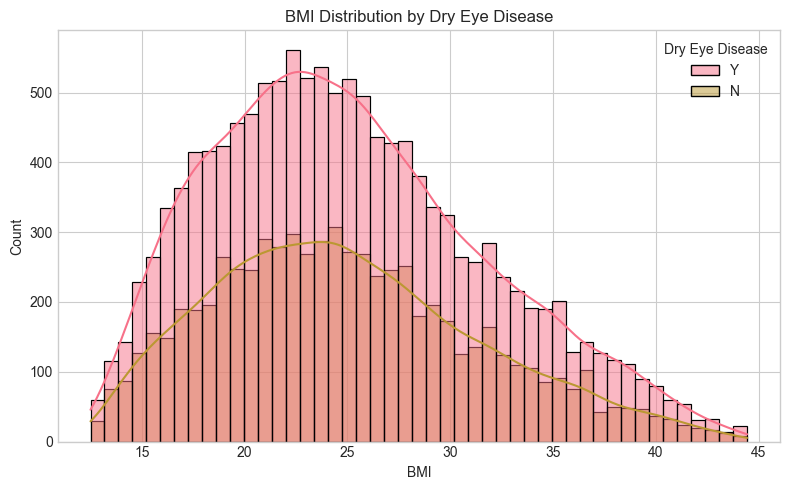

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x='BMI', hue='Dry Eye Disease', kde=True, ax=ax)
ax.set_title('BMI Distribution by Dry Eye Disease')
plt.tight_layout()
plt.show()

### 3.2 Split Blood Pressure into Systolic and Diastolic

Blood pressure is recorded as "systolic/diastolic". We need to split this into two separate features:
- **Systolic BP**: The pressure when heart beats (upper number)
- **Diastolic BP**: The pressure when heart rests (lower number)

Hypertension has been linked to increased risk of dry eye disease.

In [10]:
df[['BP_Systolic', 'BP_Diastolic']] = df['Blood pressure'].str.split('/', expand=True).astype(int)

print("Blood Pressure Statistics:")
print(df[['BP_Systolic', 'BP_Diastolic']].describe())

Blood Pressure Statistics:
        BP_Systolic  BP_Diastolic
count  20000.000000  20000.000000
mean     114.985450     74.999300
std       14.725589      8.975034
min       90.000000     60.000000
25%      102.000000     67.000000
50%      115.000000     75.000000
75%      128.000000     83.000000
max      140.000000     90.000000


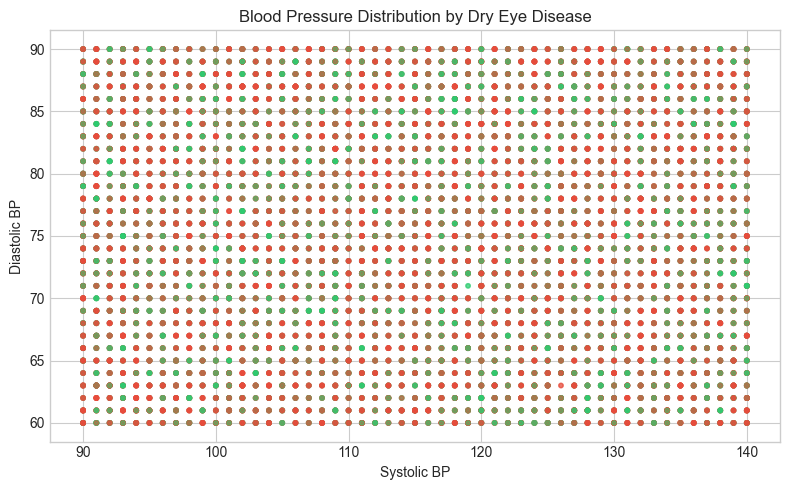

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = df['Dry Eye Disease'].map({'Y': '#e74c3c', 'N': '#2ecc71'})
ax.scatter(df['BP_Systolic'], df['BP_Diastolic'], c=colors, alpha=0.5, s=10)
ax.set_xlabel('Systolic BP')
ax.set_ylabel('Diastolic BP')
ax.set_title('Blood Pressure Distribution by Dry Eye Disease')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [12]:
df_processed = df.copy()

le = LabelEncoder()
cat_cols = df_processed.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col != 'Blood pressure':
        df_processed[col] = le.fit_transform(df_processed[col])

df_processed['Eye_Load'] = (df_processed['Average screen time'] / (df_processed['Sleep duration'] + 0.1)) * (1 + 0.5 * df_processed['Blue-light filter'])
df_processed['Screen_to_Sleep_Ratio'] = df_processed['Average screen time'] / (df_processed['Sleep duration'] + 0.1)
df_processed['Stress_Metabolic'] = df_processed['Stress level'] * df_processed['BP_Systolic']

print("Encoding & Feature Engineering complete!")

Encoding & Feature Engineering complete!


In [13]:
drop_cols = ['Dry Eye Disease', 'Blood pressure', 'Height', 'Weight']
feature_cols = [col for col in df_processed.columns if col not in drop_cols]

X = df_processed[feature_cols]
y = df_processed['Dry Eye Disease']

print(f"Features: {X.shape}, Target: {y.shape}")

Features: (20000, 28), Target: (20000,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 16000, Test: 4000


## 5. Model Training

In [15]:
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = (neg / pos) * 1.5

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=1,
    reg_lambda=1,
    eval_metric='auc',
    tree_method='hist',
    device='cuda',
    random_state=42,
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print(f"Training complete! Best iteration: {xgb_model.best_iteration}")

Training complete! Best iteration: 36


## 6. Model Evaluation

In [16]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Threshold Tuning
best_threshold, best_f1 = 0.5, 0
for tr in np.arange(0.3, 0.7, 0.01):
    y_pred_temp = (y_pred_proba >= tr).astype(int)
    f1_temp = classification_report(y_test, y_pred_temp, output_dict=True, zero_division=0)['1']['f1-score']
    if f1_temp > best_f1:
        best_f1, best_threshold = f1_temp, tr

y_pred = (y_pred_proba >= best_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Threshold: {best_threshold:.2f}")
print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
print(f"F1: {f1:.4f} | AUC: {auc_roc:.4f}")

Threshold: 0.57
Accuracy: 0.7005 | Precision: 0.7023 | Recall: 0.9382
F1: 0.8033 | AUC: 0.6084


In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Dry Eye', 'Dry Eye']))


Classification Report:
              precision    recall  f1-score   support

  No Dry Eye       0.69      0.26      0.37      1393
     Dry Eye       0.70      0.94      0.80      2607

    accuracy                           0.70      4000
   macro avg       0.70      0.60      0.59      4000
weighted avg       0.70      0.70      0.65      4000



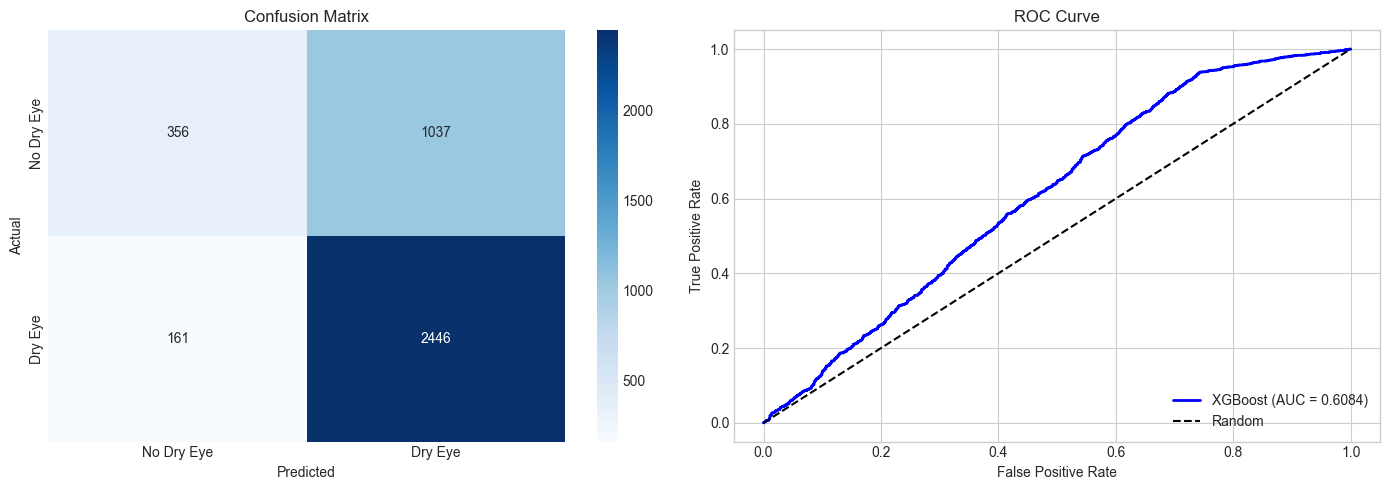

In [18]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Dry Eye', 'Dry Eye'],
            yticklabels=['No Dry Eye', 'Dry Eye'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'XGBoost (AUC = {auc_roc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Feature Importance

In [19]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Features:")
print(feature_importance.head(15).to_string(index=False))

symptom_features = ['Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye']
symptom_imp = feature_importance[feature_importance['Feature'].isin(symptom_features)]['Importance'].sum()

Top 15 Features:
                    Feature  Importance
Itchiness/Irritation in eye    0.305827
      Discomfort Eye-strain    0.262282
             Redness in eye    0.168704
          Blue-light filter    0.012365
                     Gender    0.011693
     Feel sleepy during day    0.011559
       Wake up during night    0.011504
                        BMI    0.011468
                        Age    0.011423
          Physical activity    0.010892
               BP_Diastolic    0.010884
             Sleep disorder    0.010884
      Screen_to_Sleep_Ratio    0.010858
                   Eye_Load    0.010858
                BP_Systolic    0.010765


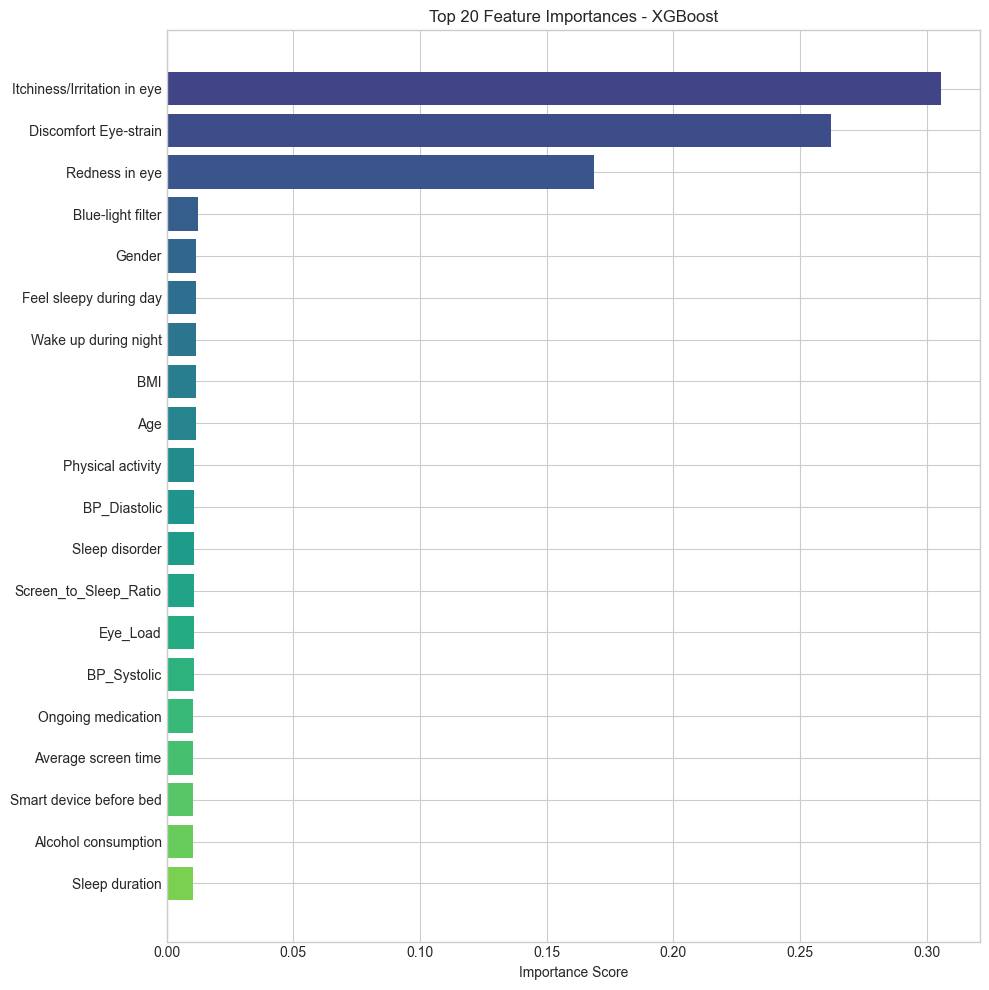

In [20]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 10))

top_n = 20
top_features = feature_importance.head(top_n)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
ax.barh(range(top_n), top_features['Importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
ax.set_title(f'Top {top_n} Feature Importances - XGBoost')

plt.tight_layout()
plt.show()

## 8. Save Model and Artifacts

In [21]:
joblib.dump(xgb_model, 'xgboost_dry_eye_model.joblib')
print("Model saved!")

Model saved!
